In [1]:
import sys
sys.path.append('../..')
from dataloader import *
from model import *
from train_eval_test import *
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import pandas as pd

2024-01-26 17:11:04.827314: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-26 17:11:04.985257: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-26 17:11:06.225974: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.6/lib64:/usr/local/cuda-12.2/lib64
2024-01-26 17:11:06.226080: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror:

In [2]:
torch.manual_seed(42)

## Load data

In [3]:
ETTh1_data = pd.read_csv('../../data/ETTh1.csv', header=None).to_numpy()

In [4]:
ETTh1_data.shape

(17420, 7)

In [5]:
batch_size = 32
n_train = 8545
n_eval = 2881
n_test = 2881
train_loader, eval_loader, test_loader = get_loaders(ETTh1_data, batch_size, n_train, n_eval, n_test, T=96, S=96)

## Train

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#writer = SummaryWriter()

cuda


In [7]:
N = 7 
T = 96 
D = 512 
S = 96 
hidden_dim = 64
num_blocks = 1 

itransformer = iTransformer(N, T, D, S, hidden_dim, num_blocks).to(device)
optimizer = torch.optim.Adam(itransformer.parameters(), lr=1e-4, weight_decay=1e-5) 


In [8]:
loss_values, loss_eval = train(itransformer, optimizer, train_loader, eval_loader, 10, device)

---- epoch :  0
loss train : 0.3867897568446285
loss eval : 0.6873449537564408
---- epoch :  1
loss train : 0.36300124177392923
loss eval : 0.6820320539515127
---- epoch :  2
loss train : 0.35355048798165234
loss eval : 0.6863144673407078
---- epoch :  3
loss train : 0.3461417366873543
loss eval : 0.6823103136636994
---- epoch :  4
loss train : 0.33848701243130663
loss eval : 0.6868076957762241
Early stopping after 4 epochs without improvement.


## Test

In [9]:
loss_test, loss_mae, target, yhat = test(itransformer, test_loader, device)
print("MSE : ", loss_test)
print("MAE : ", loss_mae)

MSE :  0.377635929394852
MAE :  0.3994915261864662


Affichage pour une modalité sur toute la durée de la prédiction

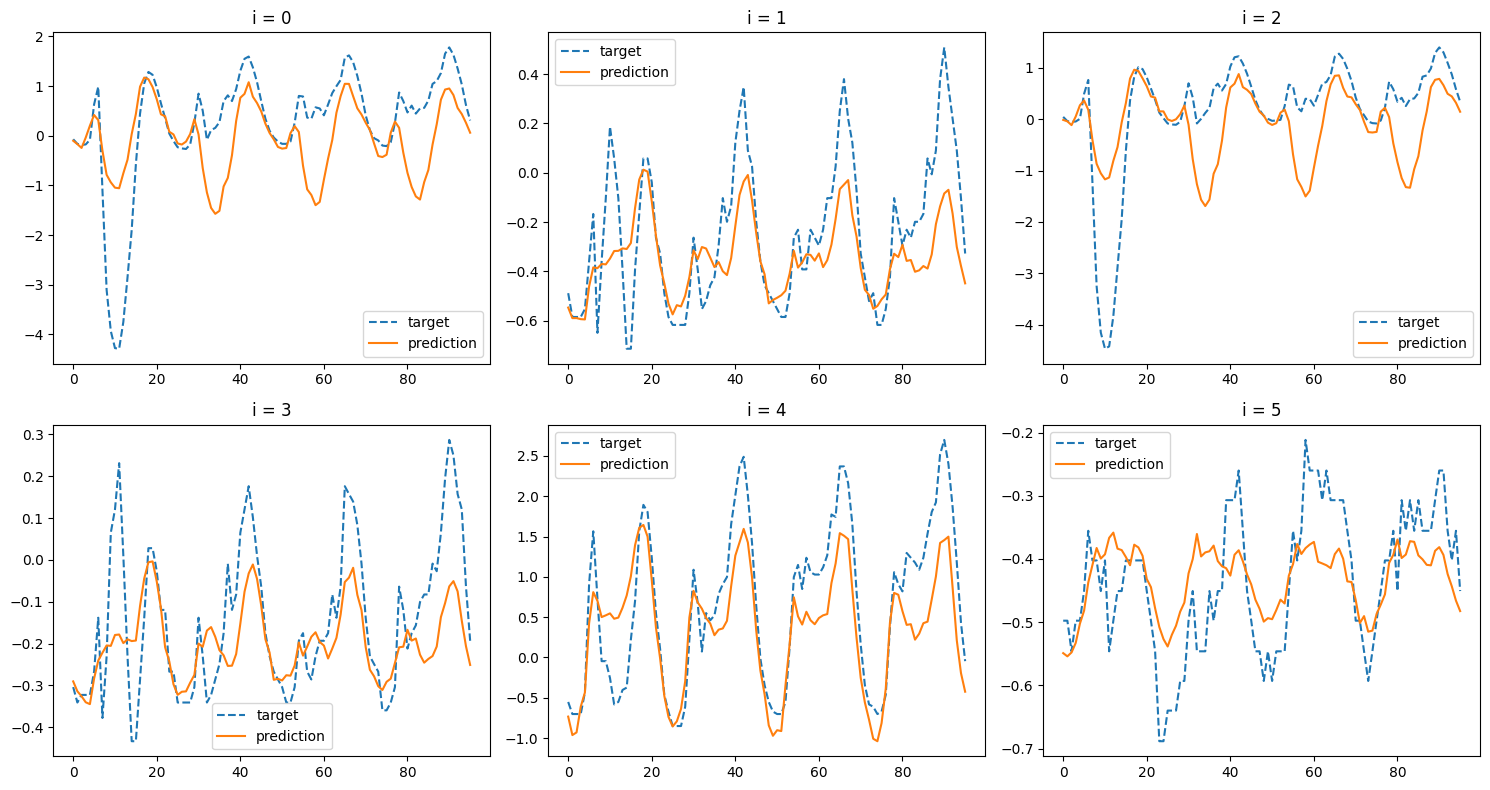

In [10]:
plt.figure(figsize=(15, 8))

for i in range(1, 7):
    plt.subplot(2, 3, i)
    current_i = i - 1
    
    plt.plot(target[0, :, current_i].to("cpu"), "--", label="target")
    plt.plot(yhat[0, :, current_i].to("cpu"), label="prediction")
    
    plt.title(f"i = {current_i}")
    plt.legend()

plt.tight_layout()
plt.show()

Affichage de toutes les modalités à un instant t

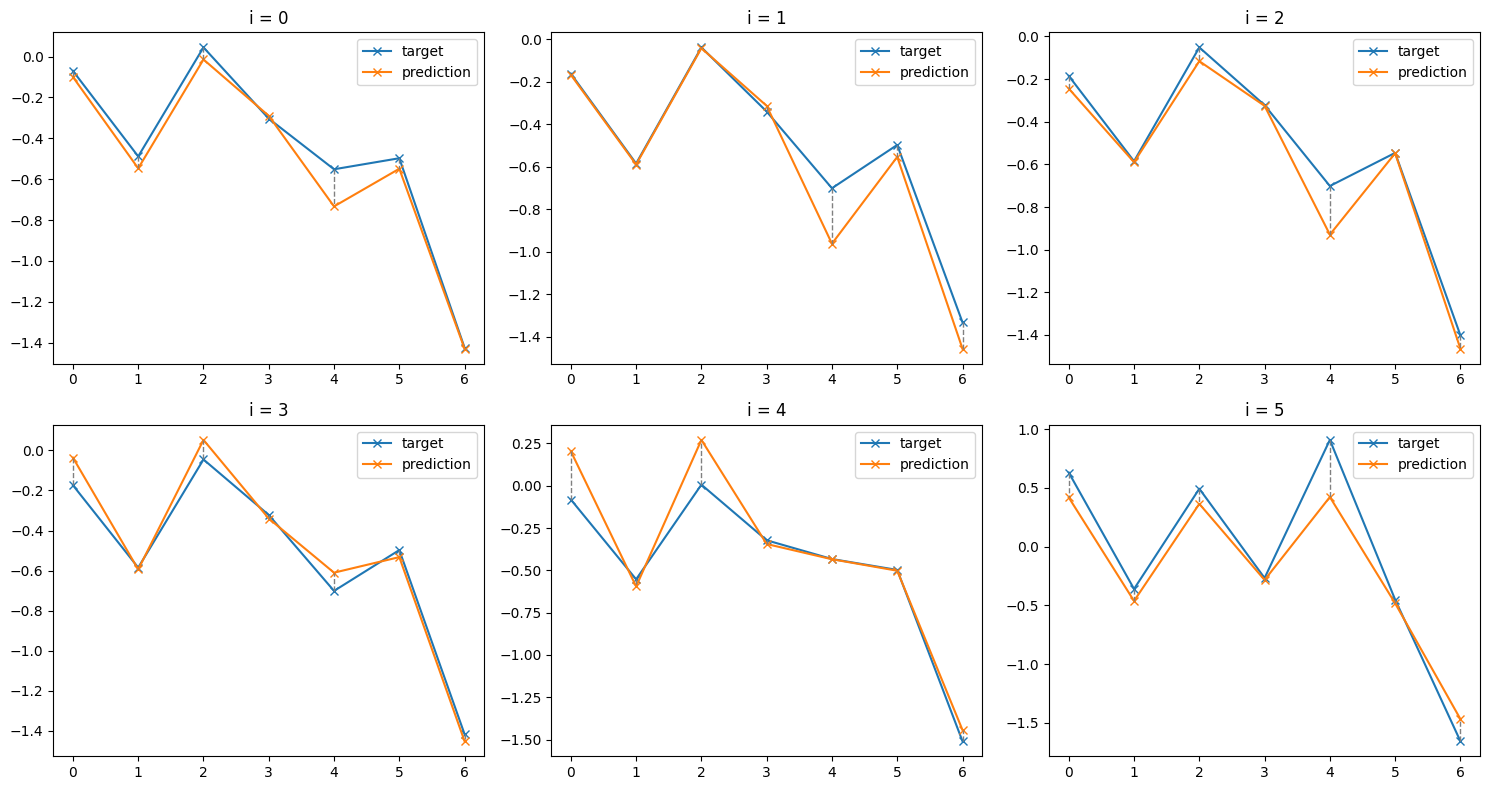

In [11]:
plt.figure(figsize=(15, 8))

for i in range(1, 7):
    plt.subplot(2, 3, i)
    
    current_i = i - 1
    
    plt.plot(np.arange(len(target[0, current_i, :7])), target[0, current_i, :20].cpu(), marker='x', label="target")
    plt.plot(np.arange(len(target[0, current_i, :7])), yhat[0, current_i, :20].cpu(), marker='x', label="prediction")

    for j in range(len(target[0, 0, :7])):
        plt.plot([j, j], [target[0, current_i, j].to("cpu"), yhat[0, current_i, j].cpu()], color='gray', linestyle='--', linewidth=1)

    plt.title(f"i = {current_i}")
    plt.legend()

plt.tight_layout()
plt.show()

## Expérience saliency 

In [12]:
LOOK_FORWARD = 96
BATCH_SIZE = 32
PATH = "../../resultats/saliency"

def perturbation_data(x, num_window, mod, mode="zero", size_window=1):
    x_noisy = x.clone()
    if mode =="zero":
        x_noisy[num_window * size_window: (num_window+1) * size_window, mod] = 0
    elif mode == "mean_mod":
        x_noisy[num_window * size_window: (num_window+1) * size_window, mod] = x_noisy[:, mod].mean(dim=0)
    elif mode =="mean_time":
        x_noisy[num_window * size_window: (num_window+1) * size_window, mod] =x_noisy[num_window * size_window: (num_window+1) * size_window, :].mean(dim=1)
    return x_noisy

def score(target, yhat, yhat_noisy):
    criterion = torch.nn.MSELoss()
    loss = criterion(target, yhat)
    loss_noisy = criterion(target, yhat_noisy)

    diff_loss = np.abs(loss.cpu().detach().numpy() - loss_noisy.cpu().detach().numpy())
    return diff_loss


def saliency_map(dataset, itransformer, x, target, N, mode="zero", size_window=1, idx_ex=0):
    saliency_map = np.zeros((N, LOOK_FORWARD//size_window))
    for mod in range(N):
        for num_window in range(LOOK_FORWARD//size_window): 
            x_noisy = perturbation_data(x, num_window, mod, mode=mode, size_window=1)
            yhat_noisy = itransformer(x_noisy.reshape((1, 96, N)))[0]
            yhat = itransformer(x.reshape((1, 96, N)))[0]
            saliency_map[mod, num_window] = score(target, yhat, yhat_noisy)

    return saliency_map, x


In [14]:
idx_ex = 0
mode="mean_time"
dataset = "ETTh1"
size_window = 1

for x_batch, target_batch in test_loader:
        x = x_batch[0].float().to(device)
        target = target_batch[0].float().to(device)
        res_saliency_map, x = saliency_map("ETTh1", itransformer, x, target, N, mode=mode, size_window=size_window, idx_ex=idx_ex)
                
        break



In [48]:
def check_results(res_saliency_map, x_variates, backward_mod, forward_mod, mode, idx_ex): 
        
    x_noisy = x_variates.clone()
    
    if mode =="zero":
        x_noisy[:, backward_mod] = 0
    elif mode == "mean_mod":
            for t in range(96):
                    x_noisy[t * size_window: (t+1) * t, backward_mod] = x_variates[:, backward_mod].mean(dim=0)
    elif mode =="mean_time":
            for t in range(96):
                    x_noisy[t * size_window: (t+1) * t, backward_mod] = x_variates[t * size_window: (t+1) * size_window, :].mean(dim=1)
    
    yhat_noisy = itransformer(x_noisy.reshape((1, 96, N)))
    yhat = itransformer(x_variates.reshape((1, 96, N)))

    yhat_noisy = yhat_noisy[0,:,forward_mod]
    yhat = yhat[0,:,forward_mod]
    target_mod = target[:,forward_mod]
    
    plt.imshow(res_saliency_map, cmap='viridis', aspect='auto')
    plt.title('Saliency Map')
    plt.xlabel('Time')
    plt.ylabel('Modality')
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(f"{PATH}/{dataset}/saliency_{mode}_{idx_ex}.pdf")
    plt.show()
    print(f"saved {PATH}/{dataset}/saliency_{mode}_{idx_ex}.pdf")

    plt.figure()
    plt.plot(x_variates[:, backward_mod].to("cpu"), "--", label=f"Modality {backward_mod}")
    plt.title(f"Lookback modality {backward_mod}")
    #plt.axvspan(3, 7, color='#fde724', alpha=0.3)
    #plt.axvspan(15, 19, color='#23878d', alpha=0.3)
    #plt.axvspan(42, 48, color='#355d8c', alpha=0.3)
    #plt.axvspan(51, 55, color='#29af7f', alpha=0.3)
    #plt.axvspan(67, 78, color='#64cb5d', alpha=0.3)
    plt.legend()
    plt.savefig(f"{PATH}/{dataset}/modality_{mode}_{idx_ex}_B{backward_mod}.pdf")
    print(f"saved {PATH}/{dataset}/modality_{mode}_{idx_ex}_B{backward_mod}.pdf")



    plt.figure()
    plt.plot(target_mod.to("cpu"), "--", label=f"target")

    plt.plot(yhat.to("cpu").detach().numpy(), label=f"prediction")
    plt.plot(yhat_noisy.to("cpu").detach().numpy(), label=f"prediction (perturbation)")
    plt.title(f"Prediction modality {forward_mod} (perturbation of {backward_mod})")
    plt.legend(loc='upper right')
    plt.savefig(f"{PATH}/{dataset}/yhat_{mode}_{idx_ex}_B{backward_mod}_F{forward_mod}.pdf")
    print(f"saved {PATH}/{dataset}/yhat_{mode}_{idx_ex}_B{backward_mod}_F{forward_mod}.pdf")
    plt.show()


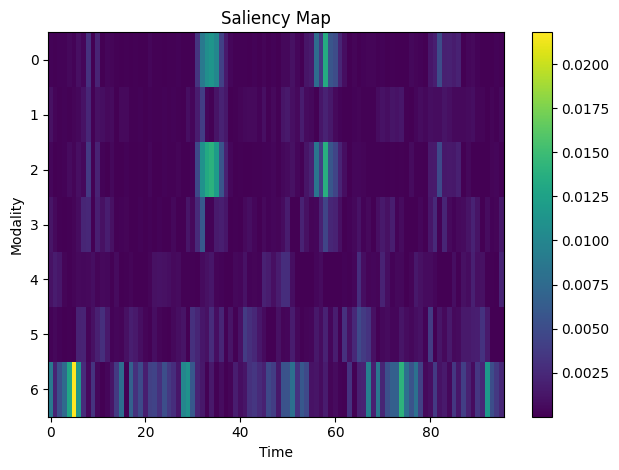

saved ../../resultats/saliency/ETTh1/saliency_mean_time_0.pdf
saved ../../resultats/saliency/ETTh1/modality_mean_time_0_B6.pdf
saved ../../resultats/saliency/ETTh1/yhat_mean_time_0_B6_F6.pdf


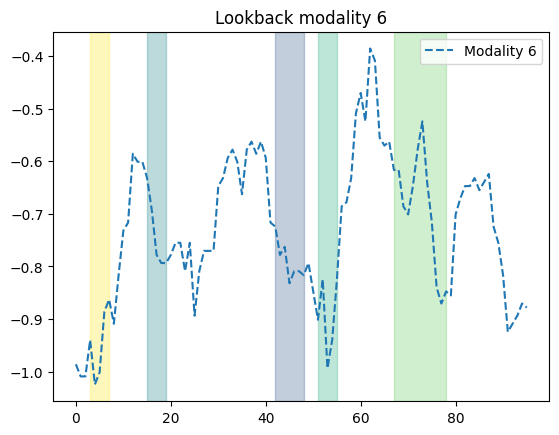

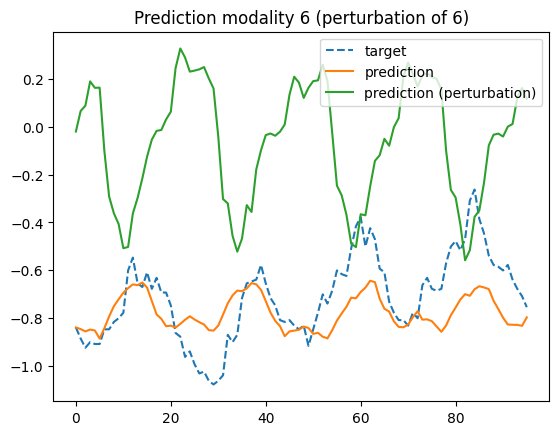

In [46]:
x_variates = x.clone()
best_mod = np.argmax(np.sum(res_saliency_map, axis=1))
forward_mod = best_mod
check_results(res_saliency_map, x_variates, best_mod, forward_mod, mode, idx_ex)

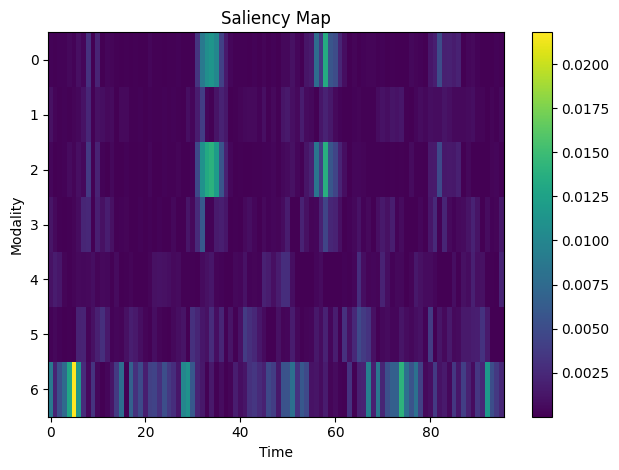

saved ../../resultats/saliency/ETTh1/saliency_mean_time_0.pdf
saved ../../resultats/saliency/ETTh1/modality_mean_time_0_B6.pdf
saved ../../resultats/saliency/ETTh1/yhat_mean_time_0_B6_F0.pdf


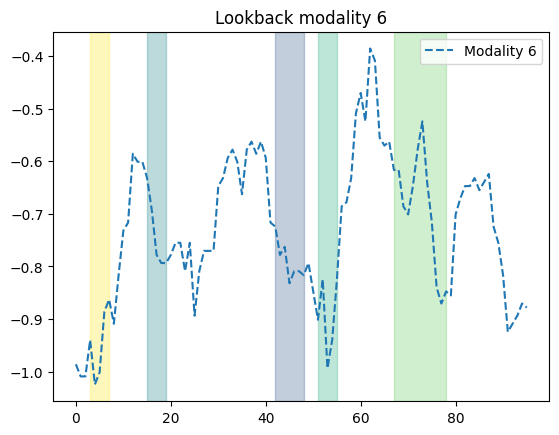

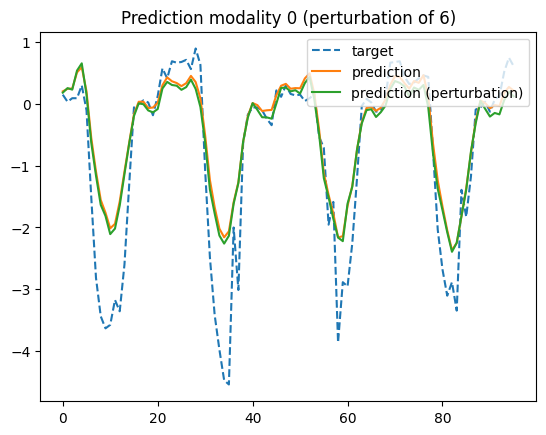

In [47]:
x_variates = x.clone()
forward_mod = 0
check_results(res_saliency_map, x_variates, best_mod, forward_mod, mode, idx_ex)

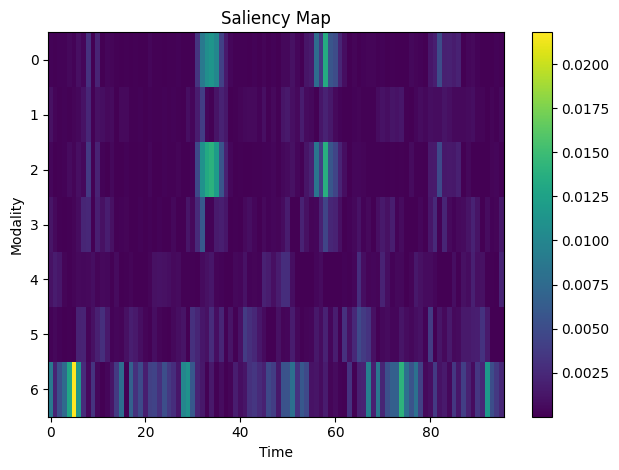

saved ../../resultats/saliency/ETTh1/saliency_mean_time_0.pdf
saved ../../resultats/saliency/ETTh1/modality_mean_time_0_B0.pdf
saved ../../resultats/saliency/ETTh1/yhat_mean_time_0_B0_F0.pdf


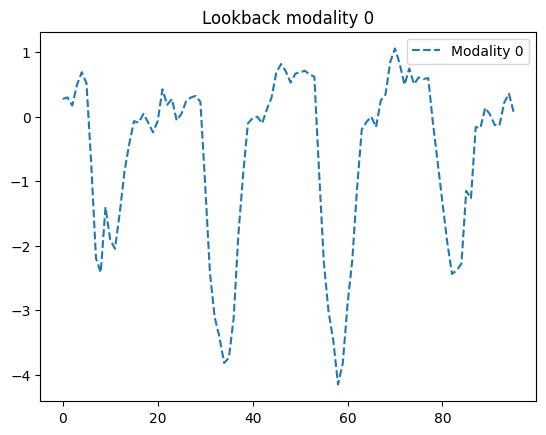

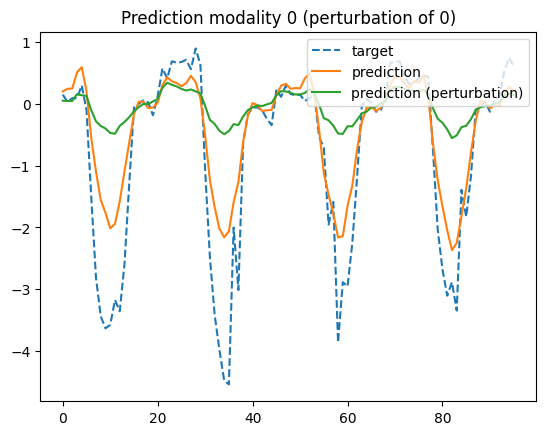

In [49]:
x_variates = x.clone()
backward_mod = 0
forward_mod = backward_mod
check_results(res_saliency_map, x_variates, backward_mod, forward_mod, mode, idx_ex)

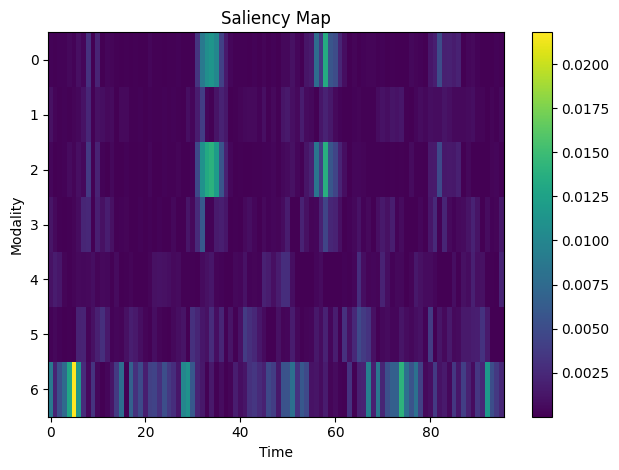

saved ../../resultats/saliency/ETTh1/saliency_mean_time_0.pdf
saved ../../resultats/saliency/ETTh1/modality_mean_time_0_B0.pdf
saved ../../resultats/saliency/ETTh1/yhat_mean_time_0_B0_F6.pdf


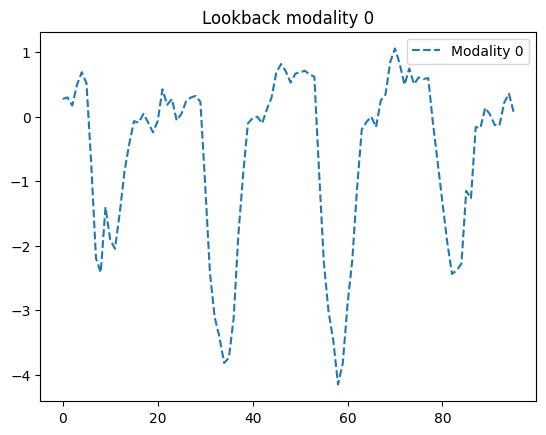

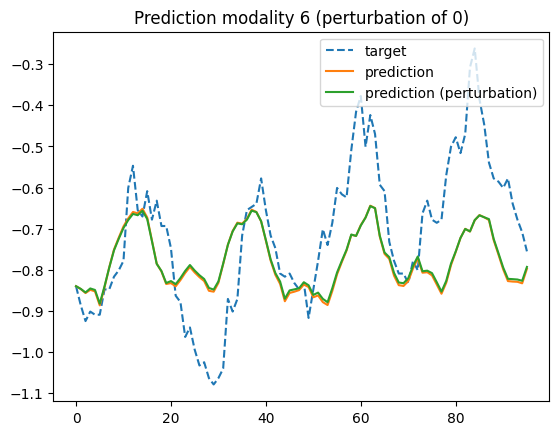

In [50]:
x_variates = x.clone()
backward_mod = 0
forward_mod = 6
check_results(res_saliency_map, x_variates, backward_mod, forward_mod, mode, idx_ex)